# Modeling

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
path = os.path.join("FINAL_updated_with_TR.xlsx")

# Read the Excel file
FINAL_no_TR = pd.read_excel(path)

# Display the first few rows
FINAL_no_TR.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (EUR_HAB),GDP (EUR_HAB_EU27_2020),GDP (MIO_EUR),GDP (MIO_NAC),GDP (MIO_PPS_EU27_2020),GDP (PPS_EU27_2020_HAB),GDP (PPS_HAB_EU27_2020),GVA (MIO_EUR),GVA (MIO_NAC),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,NaN,NaN,24942.455371,NaN,NaN,NaN,NaN,23931.324019,NaN,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,NaN,NaN,25582.147076,NaN,NaN,NaN,NaN,24614.963819,NaN,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,NaN,NaN,28422.113810,NaN,NaN,NaN,NaN,27311.621095,NaN,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,NaN,NaN,32557.042431,39186.33,20892.36,NaN,NaN,31336.257699,38146.50,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,NaN,NaN,33443.246005,39438.95,21505.74,NaN,NaN,32261.320850,38474.47,622.82


### What are the most important programming hubs?

To answer this first research question about identifying the most important programming hubs by NUTS3 region, we need to establish criteria that define what constitutes a "high programming activity" area. Here are some considerations and steps to approach this:

**Weighted Stack Overflow Metrics:** Since questions, answers, and comments on Stack Overflow are direct indicators of programming activity, they should be weighted more heavily than upvotes and downvotes. You might consider a weighted sum where questions, answers, and comments have higher weights.

**Activity Thresholds:** Establish minimum thresholds for these metrics to filter out regions with very low programming activity. This could be based on either absolute numbers or relative to the population of the region.

**Growth Over Time:** Consider the growth rate of these activities over the period from 2008 to 2020. Regions with a significant increase in activity might be more relevant than those with stagnant or declining rates.

**Economic Resilience:** Consider the economic indicators like GDP, GVA and employment.

We could use the following weights:

**Questions (40%):** Posting questions is a primary indicator of active problem-solving and learning in the programming community. It shows a need for knowledge and a willingness to seek assistance, which is fundamental in a vibrant and growing programming hub. A high volume of questions suggests a significant level of engagement in programming activities.

**Answers (40%):** Providing answers is equally crucial, as it demonstrates expertise and a community's capacity to support its members. A region with a high number of answers indicates not only active participation but also a certain level of proficiency and knowledge-sharing culture in the programming community.

**Comments (10%):** Comments, while important for clarifying questions and answers, are generally less indicative of programming activity than the questions and answers themselves. They contribute to the community engagement and collaborative problem-solving process but are a secondary activity compared to asking and answering questions.

**Upvotes (5%) and Downvotes (5%):** Upvotes and downvotes are indicators of community engagement and the quality of content being produced. However, they are more passive forms of participation compared to asking questions, providing answers, or commenting. Therefore, they are assigned a lower weight. They do, however, play a role in indicating the relevance and usefulness of the content, which is why they are included in the weighting scheme.

In [3]:
# Assign weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

FINAL_no_TR['activity'] = (FINAL_no_TR['questioncount']*weights['questions'] + 
                          FINAL_no_TR['answercount']*weights['answers'] + 
                          FINAL_no_TR['commentcount']*weights['comments'] + 
                          FINAL_no_TR['upvotecount']*weights['upvotes'] + 
                          FINAL_no_TR['downvotecount']*weights['downvotes'])

In [4]:
top_countries = FINAL_no_TR.groupby('country')['activity'].sum().sort_values(ascending=False)
top_countries

country
FR    3287366.30
IT    1917238.30
ES    1822155.95
SE    1504508.20
CH    1367466.30
TR    1142268.90
Name: activity, dtype: float64

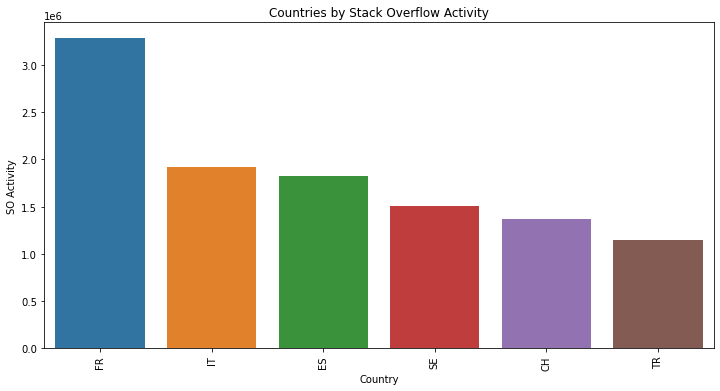

In [5]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Countries by Stack Overflow Activity')
plt.xlabel('Country')
plt.ylabel('SO Activity')
plt.xticks(rotation=90)
plt.show()

In [6]:
top_regions = FINAL_no_TR.groupby('nuts3_name')['activity'].sum().sort_values(ascending=False).head(10)
print(top_regions)

nuts3_name
Paris                     936830.30
Stockholm County          601726.20
Istanbul                  597283.50
Zürich                    490853.45
Madrid                    424617.05
Barcelona                 383257.60
Milan                     281899.75
Rome                      237735.70
Västra Götaland County    236363.85
Skåne County              235994.55
Name: activity, dtype: float64


Calculate the average SO activity:

In [7]:
FINAL_no_TR.groupby('nuts3_name')['activity'].sum().mean()

28827.686553524778

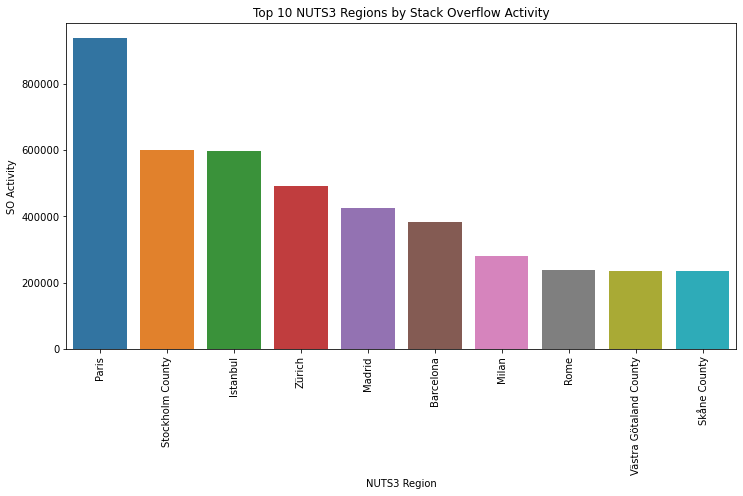

In [8]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions.index, y=top_regions.values)
plt.title('Top {} NUTS3 Regions by Stack Overflow Activity'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('SO Activity')
plt.xticks(rotation=90)
plt.show()

We can observe:

- Capital regions or regions with a lot of population tend to have a lot of programming activity (all the capitals of the countries in our dataset are represented in the Top 10)
- The broader area of Paris (Paris + Hauts-de-Seine) has a lot of programming activity (almost double the activity of the second biggest region), which could be due to its high population

**Standardization:**

It would make sense to standardize the SO activity data across regions, allowing for more accurate comparisons. Without adjusting for population size, regions with larger populations might naturally appear to have higher programming activity simply due to more people being present, not necessarily higher engagement per person.

In [9]:
# Create columns for programming activity per capita
for i in range(3,8):
    column_name = FINAL_no_TR.columns[i]
    FINAL_no_TR[column_name + ' per cap'] = FINAL_no_TR[column_name] / (FINAL_no_TR['POP (THS)'] * 1000)

In [10]:
FINAL_no_TR['activity per cap'] = (FINAL_no_TR['questioncount per cap']*weights['questions'] + 
                          FINAL_no_TR['answercount per cap']*weights['answers'] + 
                          FINAL_no_TR['commentcount per cap']*weights['comments'] + 
                          FINAL_no_TR['upvotecount per cap']*weights['upvotes'] + 
                          FINAL_no_TR['downvotecount per cap']*weights['downvotes'])

In [11]:
top_countries_str = FINAL_no_TR.groupby('country')['activity per cap'].sum().sort_values(ascending=False)
top_countries_str

country
CH    3.059469
FR    2.893959
ES    2.497220
IT    2.465557
SE    2.199374
TR    0.405267
Name: activity per cap, dtype: float64

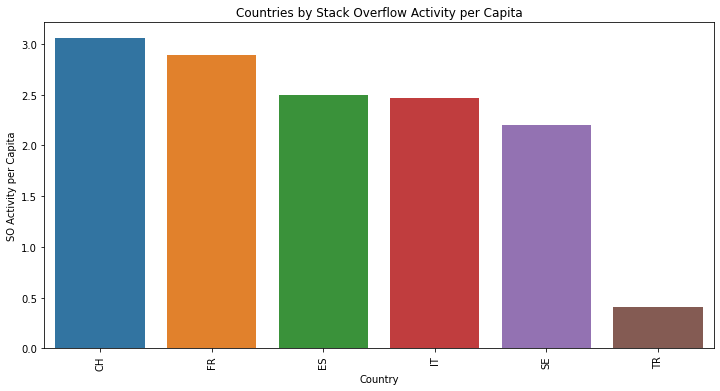

In [12]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries_str.index, y=top_countries_str.values)
plt.title('Countries by Stack Overflow Activity per Capita')
plt.xlabel('Country')
plt.ylabel('SO Activity per Capita')
plt.xticks(rotation=90)
plt.show()

In [13]:
top_regions_str = FINAL_no_TR.groupby('nuts3_name')['activity per cap'].sum().sort_values(ascending=False).head(10)
top_regions_str

nuts3_name
Balearic Islands    0.923772
Paris               0.426897
Zürich              0.334160
La Palma            0.303449
Zug                 0.284383
Stockholm County    0.271339
Basel-Stadt         0.271222
Genève              0.230338
Vaud                0.198039
Skåne County        0.181360
Name: activity per cap, dtype: float64

Calculate the average SO activity per capita:

In [14]:
FINAL_no_TR.groupby('nuts3_name')['activity per cap'].sum().mean()

0.03530246925840436

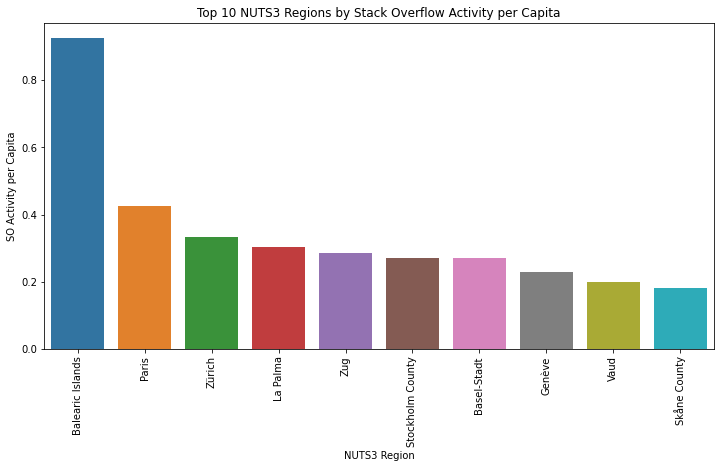

In [15]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_str.index, y=top_regions_str.values)
plt.title('Top {} NUTS3 Regions by Stack Overflow Activity per Capita'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('SO Activity per Capita')
plt.xticks(rotation=90)
plt.show()

We can see that the Top 10 regions change if you standardize the programming activity by dividing it by population. 

We can observe:

- Switzerland has a lot of important programming hubs with Zürich, Zug, Basel-Statd, Genève and Vaud.
- The Balearic Islands and La Palma seem to be very important hubs, which can be connected to their increasing popularity for digital nomads and remote workforce.
- The Balearic Islands seem to be a super-hub with more than double the activity than the second biggest region

There probably is a relation between population and programming activity. It is important to note that the identified hubs with standardization aren't more or less relevant than the ones without. 

In terms of importance, many developers in one area could mean that there is more exchange happening on a local level, such as developer courses, conferences and fairs. Additionally, we have to consider that metropoles offer a much bigger range of employment opportunites due to the industry landscape.

**Including growth of programming activity:**

So far, we only looked at the programming activity in the overall time period from 2008 until 2020. We could also consider the growth of programming activity as a metric for the importance of a programming hub.

For this we are going to compute the Compound Annual Growth Rate (CAGR).

**Formula:** $$CAGR = \left( \frac{\text{Ending Value}}{\text{Beginning Value}} \right)^{\frac{1}{\text{Number of Years}}} - 1$$



In [34]:
import math

# Function to calculate the CAGR 
def calculate_cagr(end_value, start_value, num_years):
    if start_value == 0:  # To avoid division by zero
        return None
    return (end_value/start_value)**(1/num_years) - 1

# Apply to all the NUTS3 regions
for region in FINAL_no_TR['nuts3_name'].unique():
    # Get the data for the region
    region_data = FINAL_no_TR[FINAL_no_TR.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity per cap'].values[0]
    end_value = region_data[region_data.year == 2020]['activity per cap'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity per cap'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    FINAL_no_TR.loc[FINAL_no_TR.nuts3_name == region, 'CAGR per Cap'] = cagr
    
FINAL_no_TR

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,POP (THS),activity,questioncount per cap,answercount per cap,upvotecount per cap,downvotecount per cap,commentcount per cap,activity per cap,CAGR per Cap,CAGR
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,...,586.60,104.40,0.000147,0.000285,0.000000,0.000000,0.000055,0.000178,0.365857,0.384454
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,...,595.84,1613.75,0.000621,0.003845,0.006978,0.000445,0.005508,0.002708,0.365857,0.384454
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,604.17,3692.10,0.002744,0.006741,0.020858,0.000785,0.012346,0.006111,0.365857,0.384454
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,614.88,5460.90,0.003051,0.009821,0.026688,0.003841,0.022058,0.008881,0.365857,0.384454
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,622.82,7074.50,0.005180,0.010051,0.039178,0.006703,0.029724,0.011359,0.365857,0.384454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,...,449.00,5501.70,0.010049,0.007009,0.040225,0.003526,0.032425,0.012253,0.285921,0.296603
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,...,454.99,4762.65,0.007985,0.007172,0.035682,0.003310,0.024554,0.010468,0.285921,0.296603
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,...,460.01,4976.75,0.008006,0.005469,0.042860,0.004076,0.030817,0.010819,0.285921,0.296603
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,...,464.00,3978.85,0.006373,0.004390,0.043039,0.002679,0.019841,0.008575,0.285921,0.296603


In [35]:
# Apply to all the NUTS3 regions
for region in FINAL_no_TR['nuts3_name'].unique():
    # Get the data for the region
    region_data = FINAL_no_TR[FINAL_no_TR.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity'].values[0]
    end_value = region_data[region_data.year == 2020]['activity'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    FINAL_no_TR.loc[FINAL_no_TR.nuts3_name == region, 'CAGR'] = cagr
    
FINAL_no_TR

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,POP (THS),activity,questioncount per cap,answercount per cap,upvotecount per cap,downvotecount per cap,commentcount per cap,activity per cap,CAGR per Cap,CAGR
0,2008,Aargau,CH,86,167,0,0,32,CH033,NaN,...,586.60,104.40,0.000147,0.000285,0.000000,0.000000,0.000055,0.000178,0.365857,0.384454
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,NaN,...,595.84,1613.75,0.000621,0.003845,0.006978,0.000445,0.005508,0.002708,0.365857,0.384454
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,604.17,3692.10,0.002744,0.006741,0.020858,0.000785,0.012346,0.006111,0.365857,0.384454
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,614.88,5460.90,0.003051,0.009821,0.026688,0.003841,0.022058,0.008881,0.365857,0.384454
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,622.82,7074.50,0.005180,0.010051,0.039178,0.006703,0.029724,0.011359,0.365857,0.384454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,...,449.00,5501.70,0.010049,0.007009,0.040225,0.003526,0.032425,0.012253,0.285921,0.296603
5001,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,...,454.99,4762.65,0.007985,0.007172,0.035682,0.003310,0.024554,0.010468,0.285921,0.296603
5002,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,...,460.01,4976.75,0.008006,0.005469,0.042860,0.004076,0.030817,0.010819,0.285921,0.296603
5003,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,...,464.00,3978.85,0.006373,0.004390,0.043039,0.002679,0.019841,0.008575,0.285921,0.296603


In [36]:
top_countries_CAGR_str = FINAL_no_TR.groupby('country')['CAGR per Cap'].mean().sort_values(ascending=False)
print(top_countries_CAGR_str)

country
FR    0.425376
IT    0.408932
ES    0.384378
CH    0.350178
TR    0.342493
SE    0.245467
Name: CAGR per Cap, dtype: float64


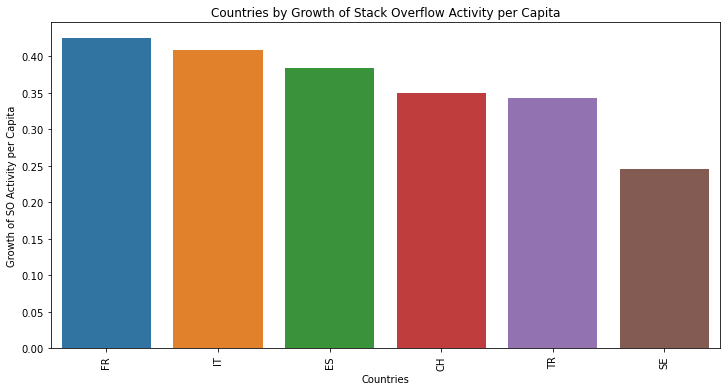

In [37]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries_CAGR_str.index, y=top_countries_CAGR_str.values)
plt.title('Countries by Growth of Stack Overflow Activity per Capita'.format(10))
plt.xlabel('Countries')
plt.ylabel('Growth of SO Activity per Capita')
plt.xticks(rotation=90)
plt.show()

Now we can visualize the top regions in terms of growth:

In [38]:
top_regions_CAGR = FINAL_no_TR.groupby('nuts3_name')['CAGR'].mean().sort_values(ascending=False).head(10)
print(top_regions_CAGR)

nuts3_name
Ardèche          1.071586
Trabzon          0.856413
Messina          0.837012
Ancona           0.825196
Ascoli Piceno    0.811369
Naples           0.806803
Balikesir        0.802891
Catania          0.800505
Lecce            0.787657
Lucca            0.785808
Name: CAGR, dtype: float64


Calculate the average Growth of SO Activity:

In [39]:
mean_values = FINAL_no_TR.groupby('nuts3_name')['CAGR'].mean()
mean = mean_values.sum() / mean_values.shape[0]
mean

0.38678401228993187

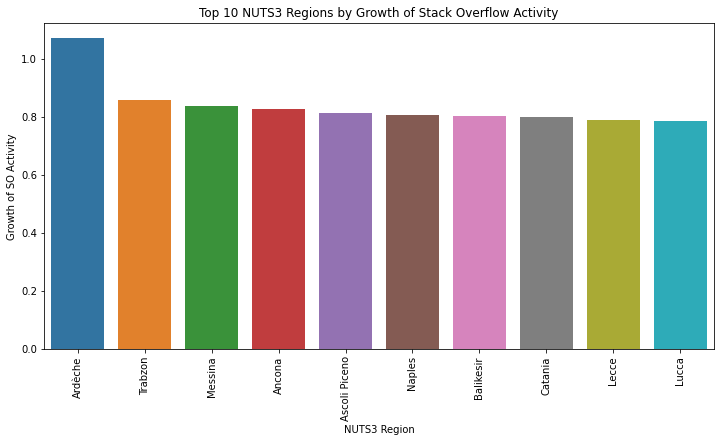

In [40]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_CAGR.index, y=top_regions_CAGR.values)
plt.title('Top {} NUTS3 Regions by Growth of Stack Overflow Activity'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Growth of SO Activity')
plt.xticks(rotation=90)
plt.show()

In [41]:
top_regions_CAGR_bc = FINAL_no_TR.groupby(['nuts3_name', 'country'])['CAGR'].mean().sort_values(ascending=False).head(10)
top_regions_CAGR_bc

nuts3_name     country
Ardèche        FR         1.071586
Trabzon        TR         0.856413
Messina        IT         0.837012
Ancona         IT         0.825196
Ascoli Piceno  IT         0.811369
Naples         IT         0.806803
Balikesir      TR         0.802891
Catania        IT         0.800505
Lecce          IT         0.787657
Lucca          IT         0.785808
Name: CAGR, dtype: float64

We can observe that 7/10 of the regions with highest average growth in SO activity are from Italy.

In [42]:
top_regions_CAGR_str = FINAL_no_TR.groupby('nuts3_name')['CAGR per Cap'].mean().sort_values(ascending=False).head(10)
print(top_regions_CAGR_str)

nuts3_name
Ardèche          1.061376
Messina          0.848218
Trabzon          0.843389
Ancona           0.826690
Ascoli Piceno    0.815805
Naples           0.809821
Catania          0.801730
Lecce            0.793183
Balikesir        0.788902
Lucca            0.787814
Name: CAGR per Cap, dtype: float64


Calculate the average Growth of SO Activity:

In [43]:
mean_values = FINAL_no_TR.groupby('nuts3_name')['CAGR per Cap'].mean()
mean = mean_values.sum() / mean_values.shape[0]
mean

0.3820927821633027

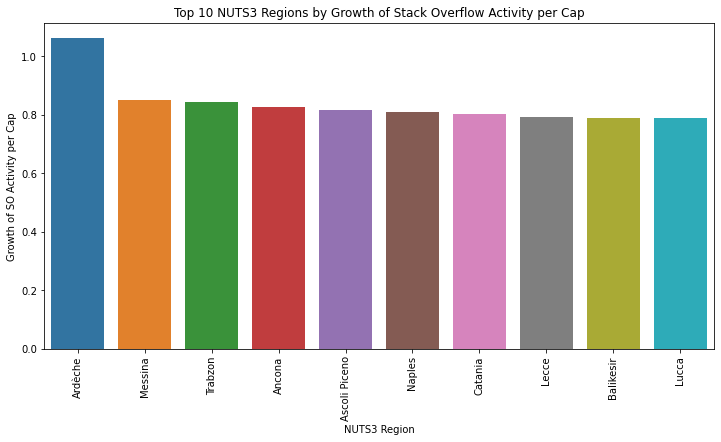

In [44]:
# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions_CAGR_str.index, y=top_regions_CAGR_str.values)
plt.title('Top {} NUTS3 Regions by Growth of Stack Overflow Activity per Cap'.format(10))
plt.xlabel('NUTS3 Region')
plt.ylabel('Growth of SO Activity per Cap')
plt.xticks(rotation=90)
plt.show()

### Modeling - Which variables will best predict high programming density “in town”?

We will start by performing our modeling without the Turkey data. First, we need to create a DataFrame with all the variables and data we created before.

In [58]:
path = os.path.join("FINAL_no_TR.xlsx")

# Read the Excel file
df = pd.read_excel(path)

# Display the first few rows
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82


Add the weighted programming activity metric:

In [59]:
# Assign weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

df['activity'] = (df['questioncount']*weights['questions'] + 
                          df['answercount']*weights['answers'] + 
                          df['commentcount']*weights['comments'] + 
                          df['upvotecount']*weights['upvotes'] + 
                          df['downvotecount']*weights['downvotes'])
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50


Add the activity per capita:

In [61]:
df['activity_per_cap'] = df['activity'] / (df['POP (THS)'] * 1000)
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,104.40,0.000178
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,1613.75,0.002708
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,3692.10,0.006111
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,5460.90,0.008881
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,7074.50,0.011359


Add the CAGR and CAGR per capita:

In [78]:
import math

# Function to calculate the CAGR 
def calculate_cagr(end_value, start_value, num_years):
    if start_value == 0:  # To avoid division by zero
        return None
    return (end_value/start_value)**(1/num_years) - 1

# Apply to all the NUTS3 regions
for region in df['nuts3_name'].unique():
    # Get the data for the region
    region_data = df[df.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity'].values[0]
    end_value = region_data[region_data.year == 2020]['activity'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    df.loc[df.nuts3_name == region, 'CAGR'] = cagr
    
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


In [80]:
# Apply to all the NUTS3 regions
for region in df['nuts3_name'].unique():
    # Get the data for the region
    region_data = df[df.nuts3_name == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity_per_cap'].values[0]
    end_value = region_data[region_data.year == 2020]['activity_per_cap'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0:
        start_value = region_data[region_data.year == 2008 + i]['activity_per_cap'].values[0]
        i += 1
       
    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years)
        
    
    # Update DataFrame
    df.loc[df.nuts3_name == region, 'CAGR_per_cap'] = cagr
    
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


Add the programmers:

In [81]:
# Defining number of programmers in each region based on the assumption made
weeks_in_year = 52
months_in_year = 12

# Experts in Region 
df["experts"] = (df["answercount"] / (weeks_in_year*2))

# Innovators in Region
df["innovators"] = df["questioncount"] / months_in_year

# Late Adopters in Region
df["late_adopters"] = ((df["upvotecount"] +  df["downvotecount"] + df["commentcount"])/ (months_in_year*15))

# Sum up all Developers
df["programmers_total"] = df["experts"] + df["innovators"] + df["late_adopters"] 

df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


Add the programmer density:

In [82]:
df['programmer_density'] = df["programmers_total"] / (df['POP (THS)'] * 1000)
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


Add GDP and employment per capita:

In [83]:
df['GDP_per_cap'] = (df["GDP (MIO_EUR)"]* 1000000) / (df['POP (THS)'] * 1000)
df['EMP_per_cap'] = (df["EMP (THS)"]* 1000) / (df['POP (THS)'] * 1000)

df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,...,0.006111,0.384454,0.365857,39.163462,138.166667,114.083333,291.413462,0.000482,47043.239172,0.577763
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,...,0.008881,0.384454,0.365857,58.067308,156.333333,179.638889,394.039530,0.000641,52948.611812,0.567094
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,...,0.011359,0.384454,0.365857,60.192308,268.833333,261.605556,590.631197,0.000948,53696.486955,0.570540


In [84]:
df.isnull().sum()

year                  0
nuts3_name            0
country               0
questioncount         0
answercount           0
upvotecount           0
downvotecount         0
commentcount          0
nuts3_code            0
EMP (THS)             0
GDP (MIO_EUR)         0
GVA (MIO_EUR)         0
POP (THS)             0
activity              0
activity_per_cap      0
CAGR                  0
CAGR_per_cap          0
experts               0
innovators            0
late_adopters         0
programmers_total     0
programmer_density    0
GDP_per_cap           0
EMP_per_cap           0
dtype: int64

In [85]:
# Save the new Dataframe to an Excel file
df.to_excel("MODELING.xlsx", index=False)

### Correlation Matrix

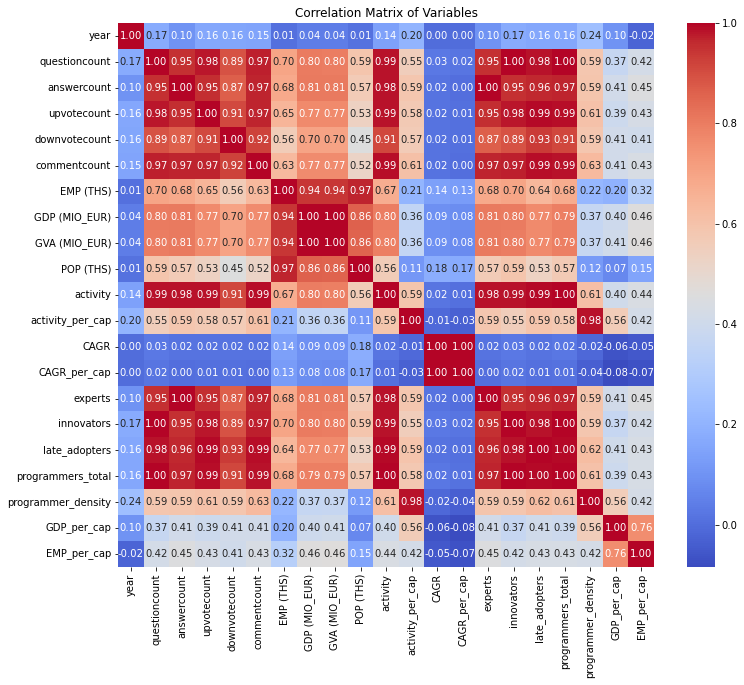

In [88]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix of Variables")
plt.show()

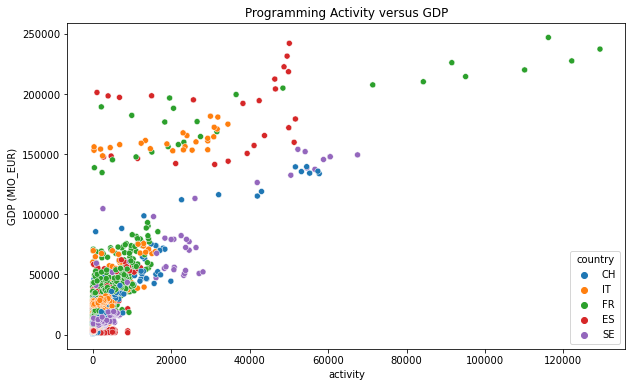

In [209]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['activity'],  
                y=df['GDP (MIO_EUR)'],
                hue=df['country']).set(title=                
                'Programming Activity versus GDP')
 
plt.show()

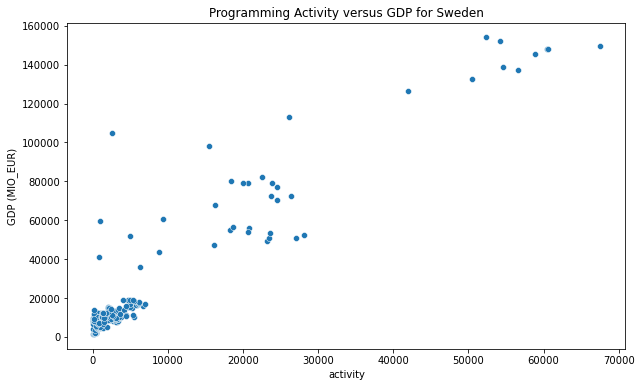

In [210]:
SE = df[df.country == 'SE']

plt.figure(figsize=(10, 6))
sns.scatterplot(x=SE['activity'],  
                y=SE['GDP (MIO_EUR)']).set(title=                
                'Programming Activity versus GDP for Sweden')

plt.show()

### Panel Data Regression

Instructions:

Link 1: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8

Link 2: https://timeseriesreasoning.com/contents/pooled-ols-regression-models-for-panel-data-sets/

In [221]:
pip install linearmodels

     |████████████████████████████████| 1.8 MB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 7.0 MB/s  eta 0:00:01
     |████████████████████████████████| 91 kB 14.5 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 43.0 MB/s eta 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.28
    Uninstalling Cython-0.29.28:
      Successfully uninstalled Cython-0.29.28
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.21.6 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


**How to decide which Model is appropriate?**

Choosing between PooledOLS and FE/RE: Basically, there are five assumptions for simple linear regression models that must be fulfilled. Two of them can help us in choosing between PooledOLS and FE/RE.

These assumptions are (1) Linearity, (2) Exogeneity, (3a) Homoskedasticity and (3b) Non-autocorrelation, (4) Independent variables are not Stochastic and (5) No Multicolinearity.

If assumption (2) or (3) (or both) are violated, then FE or RE might be more suitable.

Choosing between FE and RE: Answering this question depends on your assumption, if the individual, unobserved heterogeneity is a constant or random effect. But this question can also be answered perfoming the Hausman-Test.

Hausman-Test: In simple termns, the Hausman-Test is a test of endogeneity. By running the Hausman-Test, the null hypothesis is that the covariance between IV(s) and alpha is zero. If this is the case, then RE is preferred over FE. If the null hypothesis is not true, we must go with the FE-model.

**Step 1: Start with PooledOLS and check required assumptions**

In [231]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

dataset = df[['year', 'country', 'activity', 'GDP (MIO_EUR)']]

# Set MultiIndex
dataset = dataset.set_index(['country', 'year'])

exog = sm.tools.tools.add_constant(dataset['activity'])
endog = dataset['GDP (MIO_EUR)']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

**Check condition 3:**

Condition 3 is splitted in 3a (Homoskedasticity) and 3b (Non-Autocorrelation). Those assumptions can be tested with a number of different tests. For condition 3a, I will show you how to identify heteroscedasticity graphically as well as perform the White-Test and Breusch-Pagan-Test (both are similar). For condition 3b, I will show you the Durbin-Watson-Test.

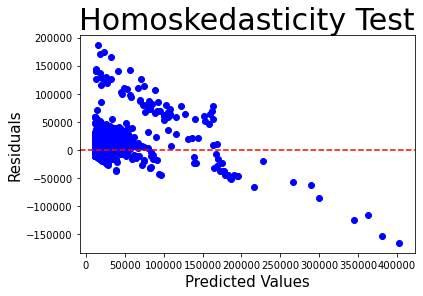

In [232]:
# 3A. Homoskedasticity
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots()
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

Basically, a residuals-plot represents predicted values (x-axis) vs. residuals (y-axis). If the plotted data points spread out, this is an indicator for growing variance and thus, for heteroskedasticity. Since this seems to be the case in our example, we might have the first violation. But let´s check this with the White- and the Breusch-Pagan-Test:

In [236]:
# 3A.2 White-Test
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

pooled_OLS_dataset = pd.concat([dataset, residuals_pooled_OLS], axis=1)
exog = sm.tools.tools.add_constant(dataset['activity']).fillna(0)
white_test_results = het_white(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test_results)))

# 3A.3 Breusch-Pagan-Test
breusch_pagan_test_results = het_breuschpagan(pooled_OLS_dataset['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan_test_results)))

{'LM-Stat': 639.8545827380219, 'LM p-val': 1.1411500357107504e-139, 'F-Stat': 381.44245329078035, 'F p-val': 3.475059534960213e-152}
{'LM-Stat': 584.071619302507, 'LM p-val': 4.880068883358792e-129, 'F-Stat': 685.015426535617, 'F p-val': 2.2199013215400468e-139}


In simple terms, if p < 0.05, then heteroskedasticity is indicated. Both tests give very small p-values (White-test: 3.475059534960213e-152, Breusch-Pagan-test: 2.2199013215400468e-139).

Therefore, we have proven our first violation! Let´s perform assumption 3b:

In [238]:
# 3.B Non-Autocorrelation
# Durbin-Watson-Test
from statsmodels.stats.stattools import durbin_watson

durbin_watson_test_results = durbin_watson(pooled_OLS_dataset['residual']) 
print(durbin_watson_test_results)

0.2962031786201269


The Durbin-Watson-Test will have one output between 0 – 4. The mean (= 2) would indicate that there is no autocorrelation identified, 0 – 2 means positive autocorrelation (the nearer to zero the higher the correlation), and 2 – 4 means negative autocorrelation (the nearer to four the higher the correlation). In our example, the result is 0.2962031786201269, which clearly indicates strong positive autocorrelation.

As a consequence, assumption 3b is also violated, so it seems that a FE-/RE-model will be more suitable.


**Step 2: Perform FE- and RE-model**

In [240]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

exog = sm.tools.tools.add_constant(dataset['activity'])
endog = dataset['GDP (MIO_EUR)']

# Random Effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 

# Fixed Effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 

# Print results
print(re_res)
print(fe_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:          GDP (MIO_EUR)   R-squared:                        0.6408
Estimator:              RandomEffects   R-squared (Between):             -1.5099
No. Observations:                3952   R-squared (Within):               0.6405
Date:                Sun, Nov 26 2023   R-squared (Overall):              0.6326
Time:                        17:54:47   Log-likelihood                -4.406e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      7046.2
Entities:                           5   P-value                           0.0000
Avg Obs:                       790.40   Distribution:                  F(1,3950)
Min Obs:                       273.00                                           
Max Obs:                       1391.0   F-statistic (robust):             7011.8
                            

Both perform similar (although, RE seems to perform slightly better). So, in order to test which model should be preferred, we will finally perfom the Hausman-test.

**Step 3: Perform Hausman-Test**

Note: Since I had problems with the hausman-function provided in econtools package (covariance was not working), I slightly changed the function. So, you are welcome to use this function, if you are following this guideline.

In [242]:
import numpy.linalg as la
from scipy import stats
import numpy as np

def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov  
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
    pval = stats.chi2.sf(chi2, df)
    
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 

print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: 22.061620148580193
degrees of freedom: 2
p-Value: 1.6194966493403753e-05


Since the p-value is very small (1.6194966493403753e-05), the null hypothesis can be rejected. Accordingly, the FE-model seems to be the most suitable, because we clearly have endogeneity in our model.

### OLS Regression Model

In [218]:
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsap
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_white

# Define the y and X variables:
y = SE['GDP (MIO_EUR)']
X = SE['activity']

# Add the placeholder for the regression intercept
X = sm.add_constant(X)

# Build the OLS regression model:
olsr_model = sm.OLS(endog=y, exog=X)

# Train the model on the (y, X) data set and fetch the training results:
olsr_model_results = olsr_model.fit()

# Print the training summary:
print(olsr_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:          GDP (MIO_EUR)   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     2177.
Date:                Thu, 23 Nov 2023   Prob (F-statistic):          1.57e-131
Time:                        15:18:53   Log-Likelihood:                -2903.5
No. Observations:                 273   AIC:                             5811.
Df Residuals:                     271   BIC:                             5818.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6745.2337    678.596      9.940      0.0

In [219]:
olsr_model_results.resid

559    -2219.655546
560    -3516.685912
561    -3577.944999
562    -4202.699694
563    -4884.516060
           ...     
3947   -2067.865930
3948     155.985874
3949    -310.147760
3950    2145.251145
3951    -926.256309
Length: 273, dtype: float64

In [213]:
print('Mean value of residual errors='+str(olsr_model_results.resid.mean()))

Mean value of residual errors=4.6107716749220975e-12


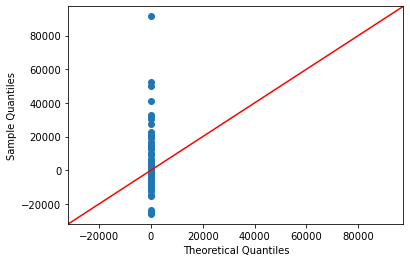

In [214]:
sm.qqplot(data=olsr_model_results.resid, line='45')
plt.show()

In [204]:
X

,const,activity
559,1.0,207.50
560,1.0,424.70
561,1.0,719.30
562,1.0,1071.00
563,1.0,1389.60
...,...,...
3947,1.0,5501.70
3948,1.0,4762.65
3949,1.0,4976.75
3950,1.0,3978.85


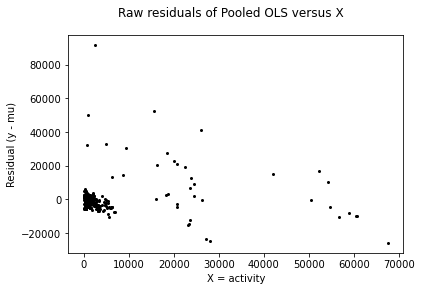

In [205]:
fig, ax = plt.subplots()
fig.suptitle('Raw residuals of Pooled OLS versus X')
plt.ylabel('Residual (y - mu)')
plt.xlabel('X = activity')
ax.scatter(X['activity'], olsr_model_results.resid, s=4, c='black', label='Residual Error')
plt.show()